In [59]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

import json
import os
import os.path as path

In [13]:
plt.rcParams["font.family"] = "Malgun Gothic" # window
plt.rcParams["font.family"] = "AppleGothic" # Apple

In [48]:
class SkinClassfierModel(nn.Module):
    def __init__(self):
        super(SkinClassfierModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(64, 32, 3, 1)
        self.dropout2 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(32, 16, 3, 1)
        self.dropout3 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(16 * 62 * 62, 6)
        self.res = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)
        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout3(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.res(x)
        return x

In [ ]:
# class ImageDataset(Dataset):
#     def __init__(self, json_dir, img_dir, transform=None):
#         self.img_dir = img_dir
#         self.json_dir = json_dir
#         self.transform = transform
        
#         self.img_files = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))])
    
#     def __len__(self):
#         return len(self.img_files)
    
#     def __getitem__(self, idx):
#         img_name = self.img_files[idx]
#         img_path = os.path.join(self.img_dir, img_name)
#         json_path = os.path.join(self.json_dir, os.path.splitext(img_name)[0] + ".json")
#         image = Image.open(img_path).convert("RGB")
        
#         with open(json_path, 'r', encoding='utf-8') as f:
#             annot = json.load(f)
        
#         mask = np.zeros((h, w), dtype=np.uint8)

['건선', '아토피', '여드름', '정상', '주사', '지루']
{'건선': 0, '아토피': 1, '여드름': 2, '정상': 3, '주사': 4, '지루': 5}


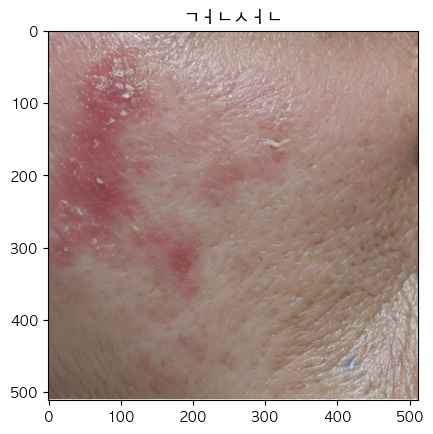

In [50]:
dataset_train = datasets.ImageFolder(root=path.join("dataset", "training", "resource"))

print(dataset_train.classes)
print(dataset_train.class_to_idx)
idx_to_class = {v:k for k , v in dataset_train.class_to_idx.items()}

img, label = dataset_train[0]
plt.imshow(img)
plt.title(f"{idx_to_class[label]}")
plt.show()

dataset_valid = datasets.ImageFolder(root=path.join("dataset", "validation", "resource"))

In [51]:
model = SkinClassfierModel()
print(model)

SkinClassfierModel(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=61504, out_features=6, bias=True)
  (res): Softmax(dim=1)
)


In [60]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.0001)

transform = transforms.Compose([
  transforms.Resize((512, 512)),
  transforms.ToTensor()
])

In [65]:
def train_one_epoch(epoch_index):
  running_loss = 0.
  last_loss = 0.

  for i, data in enumerate(dataset_train):
    inputs, labels = data

    image = transform(inputs).unsqueeze(0)
    optimizer.zero_grad()
    outputs = model(image)

    loss = loss_fn(outputs, torch.tensor([labels]))
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 0:
      last_loss = running_loss / 1000 # loss per batch
      print('  batch {} loss: {}'.format(i + 1, last_loss))
      running_loss = 0.
    
  return last_loss

In [66]:
EPOCHS = 5
best_vloss = 1_000_000.

for epoch in range(EPOCHS):
  model.train(True)
  avg_loss = train_one_epoch(epoch)

  model.eval()

  with torch.no_grad():
    for i, vdata in enumerate(dataset_valid):
      vinputs, vlabels = vdata
      vimage = transform(vinputs).unsqueeze(0)
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i + 1)
  print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

  batch 1 loss: 0.0017809712886810304
  batch 101 loss: 0.10581282460689545
  batch 201 loss: 0.10435917377471923
  batch 301 loss: 0.10435917377471923
  batch 401 loss: 0.10435917377471923
  batch 501 loss: 0.10435917377471923
  batch 601 loss: 0.10435917377471923


KeyboardInterrupt: 